In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision import transforms

def make_deeplab(device):
    deeplab = deeplabv3_resnet101(pretrained=True).to(device)
    deeplab.eval()
    return deeplab

deeplab_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def apply_deeplab(deeplab, img, device):
    input_tensor = deeplab_preprocess(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = deeplab(input_batch.to(device))['out'][0]
    output_predictions = output.argmax(0).cpu().numpy()
    return (output_predictions == 15)

In [2]:
device = torch.device("cpu")
deeplab = make_deeplab(device)

In [3]:
import sys
sys.path.append("./FBA_Matting")

from demo import np_to_torch, pred, scale_input
from dataloader import read_image, read_trimap
from networks.models import build_model


In [4]:
class Args:
    encoder = 'resnet50_GN_WS'
    decoder = 'fba_decoder'
    weights = 'FBA.pth'

args=Args()
model = build_model(args)

modifying input layer to accept 11 channels


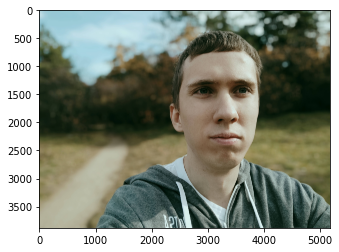

In [5]:
f_name = "./test.jpg"
img_orig = cv2.imread(f_name, 1)
plt.imshow(img_orig[:, :, ::-1])
plt.show()

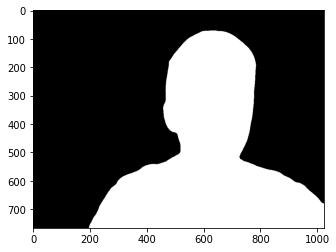

In [6]:
k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
img = cv2.resize(img_orig, None, fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)
mask = apply_deeplab(deeplab, img, device)

plt.imshow(mask, cmap="gray")
plt.show()

In [7]:
trimap = np.zeros((mask.shape[0], mask.shape[1], 2))
trimap[:, :, 1] = mask > 0
trimap[:, :, 0] = mask == 0
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25))

trimap[:, :, 0] = cv2.erode(trimap[:, :, 0], kernel)
trimap[:, :, 1] = cv2.erode(trimap[:, :, 1], kernel)

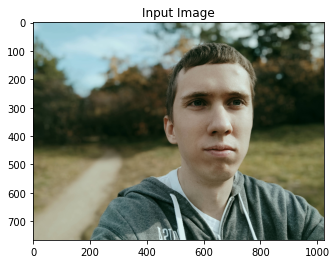

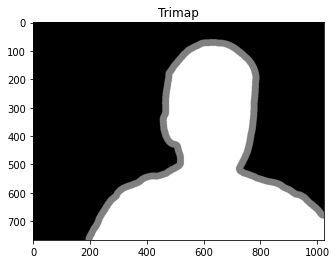

In [8]:
plt.title('Input Image')
plt.imshow(img[:, :, ::-1])
plt.show()

trimap_im =  trimap[:,:,1] + (1-np.sum(trimap,-1))/2
plt.title('Trimap')
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

In [9]:
fg, bg, alpha = pred((img/255.0)[:, :, ::-1], trimap, model)

./FBA_Matting/networks/models.py:257: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  F = ((alpha * img + (1 - alpha**2) * F - alpha * (1 - alpha) * B))


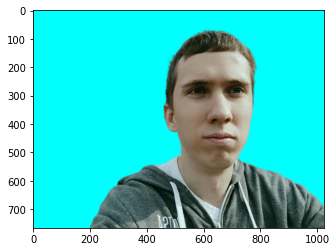

In [10]:
green = np.zeros(fg.shape)
green[:, :, :] = np.array([0, 1, 1])
blend = fg*alpha[:,:,None] + green*(1 - alpha[:,:,None])
plt.imshow(blend)
plt.show()

In [11]:
img_ = img_orig.astype(np.float32)/255
alpha_ = cv2.resize(alpha, (img_.shape[1], img_.shape[0]), cv2.INTER_LANCZOS4)
fg_alpha = np.concatenate([img_, alpha_[:, :, np.newaxis]], axis=2)
cv2.imwrite(f_name + ".png", (fg_alpha*255).astype(np.uint8))

True